In [1]:
%load_ext autoreload
%autoreload 2

import glob
import logging
import numpy as np
from importlib import reload  # Not needed in Python 2

import torch
from torch import nn
import torch.nn.functional as F
from torchvision.models import ResNet
from torch.utils.data import DataLoader,Dataset


from dataset.ASdataset import AS_Data
from dataset.ASdataset_obs_train_input import AS_Data_obs

device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
reload(logging)
logging.basicConfig(level=logging.INFO,#控制台打印的日志级别
                    filename='logging.txt',
                    filemode='a',##模式，有w和a，w就是写模式，每次都会重新写日志，覆盖之前的日志
                    #a是追加模式，默认如果不写的话，就是追加模式
                    format=
                    '%(asctime)s : %(message)s',
                    )

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

def image_show(im,title = '',r=10,base=80):
    im[:r,:r] = base
    im[r,r] = 0
    im[im>base] = base
    plt.title(title)
    plt.imshow(im[::-1])
    plt.show()
    
# logging.info('\n\n\n\n\n')
# logging.info('with 3 conv grid to concat\n')
# logging.info('2res block, use simple feature: EM inventory simple,2d ALL,3d ALL\n')

class Tensor_Parameter(nn.Module):
    def __init__(self,):
        super(Tensor_Parameter,self).__init__()
        self.Input = nn.Parameter(torch.zeros(1))
    
    def forward(self,x):
        self.Input.data = x
        return self.Input


class Focal_loss_regression(nn.Module):
    def __init__(self,max_update=10,_lambda=2,):
        super(Focal_loss_regression,self).__init__()
        self._lambda = _lambda
        max_update = np.power(1/max_update,1/_lambda)
        max_update = 1/max_update
        max_update = 1/(max_update-1)
        self.max_update = max_update
        
    def forward(self,pred,target):
        diff_abs = torch.abs(pred-target)
        diff_max = (1+self.max_update)*torch.max(diff_abs)
#         diff_max.detach()
        rate = torch.pow((1-1/diff_max*diff_abs)**self._lambda,-1)
        diff_abs = rate*diff_abs
        
#         return diff_abs
        return torch.mean(diff_abs)

In [ ]:
T = 24
batch = 1
pollution = ['PM25','O3']
cfg = {'EM':'/AS_data/Emis_with_foreign_npy/EM_2015_*',
      'label':'/AS_data/Conc_npy/TOTAL_2015_*',
      'grid':'/AS_data/Grid_npy/grid_27_182_232.npy',
      'METCRO2D':'/AS_data/METCRO2D_npy/METCRO2D_2015_*',
      'METCRO3D':'',
      'METCRO3D_5height':'',
      'obs_label':'/AS_data/obs_npy/obs2015_*'}

# cfg = {'EM':'/AS_data/Emis_with_foreign_npy/EM_2015_01*',
#         'label':'/AS_data/Conc_npy/TOTAL_2015_01*',
#         'grid':'/AS_data/Grid_npy/grid_27_182_232.npy',
#         'METCRO2D':'/AS_data/METCRO2D_npy/METCRO2D_2015_01*',
#         'METCRO3D':'',
#         'METCRO3D_5height':'',
#         'obs_label':'/AS_data/obs_npy/obs2015_01_*'}

### remove CH4,AACD,ACET
EM_idx = np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, \
                     10, 11, 12, 13, 14, 15, 16,17, 18, 19, \
                     20, 21, 22, 23, 24, 25, 26, 27, 28, 29, \
                     30, 31, 32, 33,34, 35, 36, 37, 38, 39, \
                     42, 43, 44, 45, 46, 47, 48, 50])

# EM_idx = np.array([0,2,3,4,8,9,10,32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,49, 50])
# EM_idx = np.array([6,7])

print('train data is loading ')
Data = AS_Data_obs(cfg,left = 0,right = 1,window = T,pollution = pollution,EM_idx = EM_idx)
trainloader = DataLoader(Data,batch_size=batch,shuffle=True)
print(len(Data))
print(Data.EM_idx)
# print('test data is loading ')
# test_Data = AS_Data_obs(cfg,left = 0.75,right = 0.98,window = 6)
# testloader = DataLoader(test_Data,batch_size=1,shuffle=False)
# print(len(test_Data))

train data is loading 
/AS_data/Conc_npy/TOTAL_2015_01_NO2_SO2_O3_PM25_PM10_CO__744_6_182_232.npy   is loading
/AS_data/Conc_npy/TOTAL_2015_02_NO2_SO2_O3_PM25_PM10_CO__672_6_182_232.npy   is loading
/AS_data/Conc_npy/TOTAL_2015_04_NO2_SO2_O3_PM25_PM10_CO__720_6_182_232.npy   is loading
/AS_data/Conc_npy/TOTAL_2015_07_NO2_SO2_O3_PM25_PM10_CO__744_6_182_232.npy   is loading
/AS_data/Conc_npy/TOTAL_2015_10_NO2_SO2_O3_PM25_PM10_CO__744_6_182_232.npy   is loading
/AS_data/Emis_with_foreign_npy/EM_2015_01_744_51_182_232.npy   is loading
/AS_data/Emis_with_foreign_npy/EM_2015_02_672_51_182_232.npy   is loading
/AS_data/Emis_with_foreign_npy/EM_2015_04_720_51_182_232.npy   is loading
/AS_data/Emis_with_foreign_npy/EM_2015_07_744_51_182_232.npy   is loading
/AS_data/Emis_with_foreign_npy/EM_2015_10_744_51_182_232.npy   is loading


In [ ]:
from model.res_model_LSTM import res8
from model.unet_model_LSTM import UNet

# test_model = res8(51+34,27,inplanes=64,layers = [2],T=24) #+5*16
# name = 'res_2layer_correctdata'
# test_model.load_state_dict(torch.load('model_save/res_2layer_9_epoch.t'))
test_model = UNet(51+34,27,T=T,bilinear=False,pre_dim = len(pollution)) #+80
t2p = Tensor_Parameter()

name = 'unet2'

test_model.to(device)
t2p.to(device)
criterion = torch.nn.L1Loss()
# optimizer = torch.optim.Adam(test_model.parameters(),lr=1e-3)
optimizer = torch.optim.Adam(t2p.parameters(),lr=1e-2)
test_model.load_state_dict(torch.load('model_save/unet_LSTM_ALL_prelu_PM25_O3__best_epoch.t'))
# test_model.load_state_dict(torch.load('model_save/o3_best_unet2_1month_65_epoch.t'))

In [ ]:
def score(model,loader,criterion= nn.L1Loss() ):
    model.eval()
    ls = []
    for idx,i in enumerate(loader):
        with torch.no_grad():
            indexes,input,grid,yt_1,label,obs = i[0],i[1],i[2],i[3],i[4],i[5]
            input,grid,yt_1,label,obs = input.to(device),grid.to(device),yt_1.to(device),label.to(device),obs.float().to(device)
            input = t2p(input)
            y_pred = model(input,grid,yt_1)
            
            Data.update_labels(indexes,y_pred)
            if torch.sum(obs!=-999)==0:
                continue
            
            cur_loss = []
            for pollution in range(y_pred.shape[1]):
                cur_pred = y_pred[:,pollution]
                cur_obs = obs[:,pollution]
                loss = criterion(cur_pred[cur_obs!=-999],cur_obs[cur_obs!=-999])
                cur_loss.append(loss.cpu().data)
            ls.append(cur_loss)
        
    return np.mean(np.array(ls),axis = 0)

In [ ]:
for epoch in range(25):
    logging.info('-----------{}-----------'.format(epoch))
    ls = []
    
    test_model.eval()
    test_model.rnn.train()
    for idx,i in enumerate(trainloader):
        
        indexes,input,grid,yt_1,label,obs = i[0],i[1],i[2],i[3],i[4],i[5]
        input,grid,yt_1,label,obs = input.to(device),grid.to(device),yt_1.to(device),label.to(device),obs.to(device)
        input = t2p(input)
        y_pred = test_model(input,grid,yt_1)

        if torch.sum(obs!=-999)==0:
            continue
        optimizer.zero_grad()
        
        loss = criterion(y_pred[obs!=-999],obs[obs!=-999])
        loss.backward()
        optimizer.step()
        ls.append(loss.cpu().data)
        
        #udpate input parameter
        Data.update(indexes,t2p.Input.data)

#         Data.update_labels(indexes,y_pred)
        if len(ls)%400==0:
            logging.info('epoch {} cur loss {}'.format(epoch,np.mean(ls)))
    print('epoch {} cur loss {}'.format(epoch,np.mean(ls)))
    logging.info('epoch {} cur loss {}'.format(epoch,np.mean(ls)))

    if epoch%3 == 0:
        test_score_L1 = score(test_model,trainloader,criterion = nn.L1Loss()) 
        logging.info('-------------cur test loss L1:  {}'.format(','.join([str(s) for s in test_score_L1])))

    if epoch%10 == 0:
        for idx,month in enumerate(['01','02','04','07','10']):
            np.save('/AS_data/finetune_input_prelu_PM25_O3/month_{}_finetune_input.npy'.format(month),Data.EM[idx])

In [7]:
for idx,month in enumerate(['01','02','04','07','10']):
    print(idx)
    np.save('/AS_data/finetune_input_VOC_rm_CH4_npy/month_{}_finetune_input.npy'.format(month),Data.EM[idx])

0
1
2
3
4


In [5]:
fine_inputs = []
for filename in sorted(glob.glob('/AS_data/finetune_input_VOC_rm_CH4_npy/month_01*')):
    print(filename+'   is loading')
    EM = np.load(filename)
    tick,_,W,H = EM.shape
    print(tick)
    fine_inputs.append(EM[:].copy())

/AS_data/finetune_input_VOC_rm_CH4_npy/month_01_finetune_input.npy   is loading
744


In [6]:
his_idx = np.array([1])
his_value = Data.EM[0][:,his_idx].copy()

Data.EM[0][:,his_idx] = his_value

# test_score_L1 = score(test_model,trainloader,criterion = nn.L1Loss()) 
# logging.info('-------------cur test loss L1:  {}'.format(test_score_L1))
# print('-------------cur test loss L1:  {}'.format(test_score_L1))

In [ ]:
import numpy as np
# idx_search = list(range(51))
idx_search = [0,2,3,4,8,9,10,32, 33, 34, 35, 36, 37, 38, 39, 42, 43, 44, 45, 46, 47, 48, 50]
def combination(nums):
    if len(nums) == 1:
        return [[nums[0]],[]]
    f1_end = combination(nums[1:])
    return [[nums[0]]+i for i in f1_end]+f1_end


combine_idx_search = [idx_search] + [idx_search[:i]+idx_search[i+1:] for i in range(len(idx_search))]
# combine_idx_search = [np.array(i) for i in combination(idx_search)]


for idx in combine_idx_search:
    Data.EM[0][:,his_idx] = his_value
    his_idx = idx
    his_value = Data.EM[0][:,his_idx].copy()
    
    Data.EM[0][:,idx] = fine_inputs[0][:,idx]
    test_score_L1 = score(test_model,trainloader,criterion = nn.L1Loss()) 
    logging.info('-------------EM idx is {},cur test loss L1:  {}'.format(idx,test_score_L1))
    print('-------------EM idx is {},cur test loss L1:  {}'.format(idx,test_score_L1))

In [13]:
Data.obs_label[0].shape

(744, 2, 182, 232)

0


/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


nan


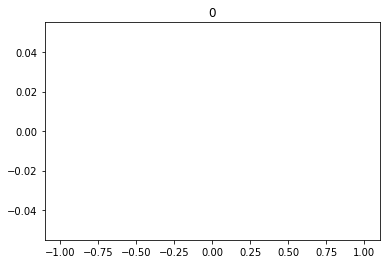

0.4014302


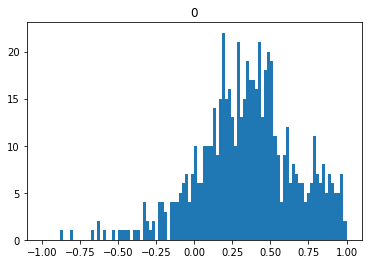

0.4014302


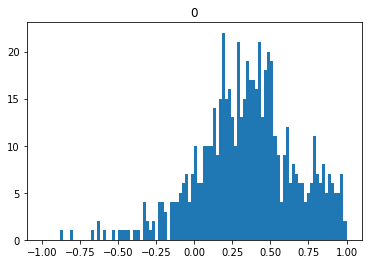

1
nan


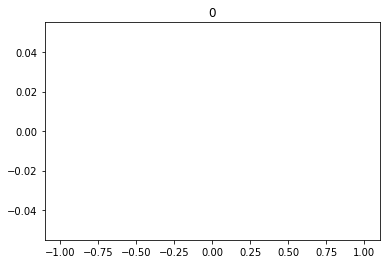

0.3820005


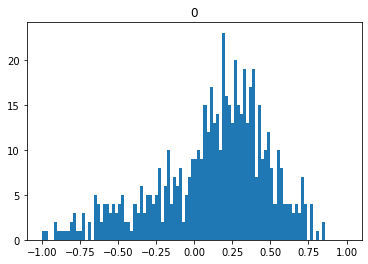

0.3820005


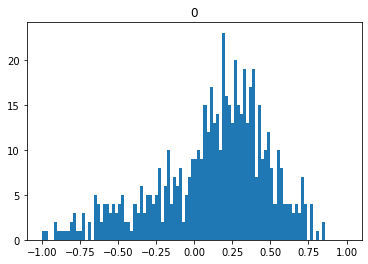

In [18]:
for i in range(len(Data.obs_label)):
    for pollution in range(len(Data.pollution_idx)):
        print(pollution)
        obs = Data.obs_label[i][:,pollution].copy()
        fine_l = Data.finetune_label[i][:,pollution].copy()
        ctm_l = Data.label[i][:,pollution].copy()

        obs[Data.obs_label[i][:,pollution]==-999] = 0
        fine_l[Data.obs_label[i][:,pollution]==-999] = 0
        ctm_l[Data.obs_label[i][:,pollution]==-999] = 0

        obs = np.sum(obs,axis = 0)
        fine_l = np.sum(fine_l,axis = 0)
        ctm_l = np.sum(ctm_l,axis = 0)
        
        a = (obs-fine_l)/(obs+1e-3)
        b = (fine_l-ctm_l)/(obs+1e-3)
        c = (obs-ctm_l)/(obs+1e-3)
        
        print(np.mean(np.abs(a[a!=0])))
        plt.hist(a[a!=0].reshape(-1),range=(-1,1),bins = 100)
        plt.title(i)
        plt.show()

        plt.hist(b[b!=0].reshape(-1),range=(-1,1),bins = 100)
        print(np.mean(np.abs(b[b!=0])))
        plt.title(i)
        plt.show()

        plt.hist(c[c!=0].reshape(-1),range=(-1,1),bins = 100)
        print(np.mean(np.abs(c[c!=0])))
        plt.title(i)
        plt.show()

In [8]:
print(1)

1


In [31]:
string = ''''''

In [ ]:
ls = []
for i in string.split('\n'):
    if 'test' in i:
        ls.append(float(i.split(' ')[-1]))
        print(ls[-1])